데이터 포인트 수: 400
Memorization 점수 범위: 0.000 ~ 0.674
Simplicity 점수 범위: 0.304 ~ 1.000


/tmp/ipykernel_1049920/196660542.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


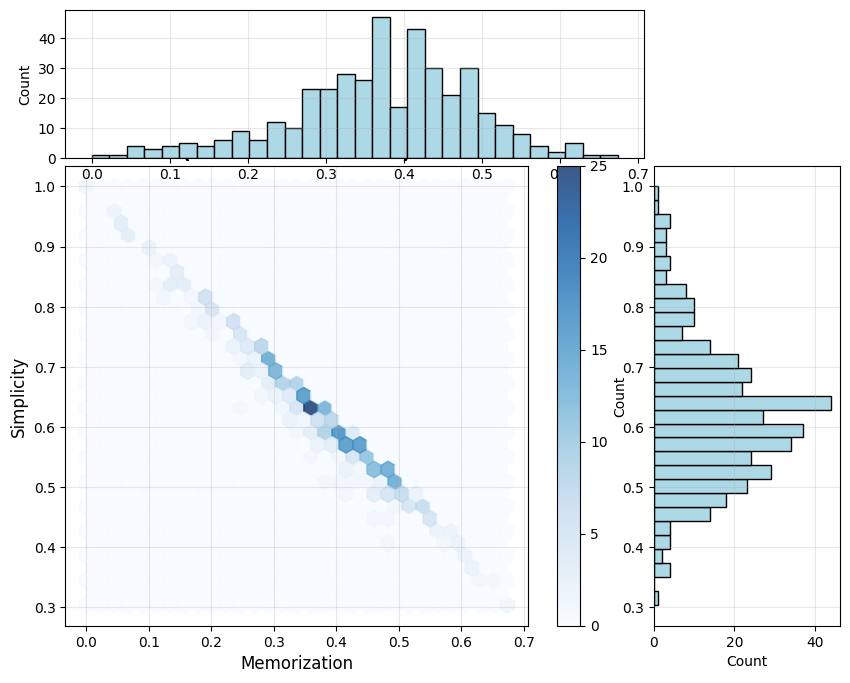

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib.gridspec as gridspec

# 데이터 로드
file_path = "/root/tofu/add/unlearning_analysis/results/dual_model_analysis_locuslab_TOFU_forget10_results.json"

with open(file_path, "r") as f:
    data = json.load(f)

# DataFrame으로 변환
df = pd.DataFrame(data["dual_model_results"])

# 필요한 컬럼만 추출
df_subset = df[["memorization_score", "simplicity_score"]].dropna()

print(f"데이터 포인트 수: {len(df_subset)}")
print(f"Memorization 점수 범위: {df_subset['memorization_score'].min():.3f} ~ {df_subset['memorization_score'].max():.3f}")
print(f"Simplicity 점수 범위: {df_subset['simplicity_score'].min():.3f} ~ {df_subset['simplicity_score'].max():.3f}")

# 그리드 레이아웃 정의
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# 메인 hexbin 플롯
ax_main = fig.add_subplot(gs[1:,:3])
hb = ax_main.hexbin(
    df_subset["memorization_score"], 
    df_subset["simplicity_score"],
    gridsize=30,
    cmap="Blues",
    alpha=0.8
)
ax_main.set_xlabel("Memorization", fontsize=12)
ax_main.set_ylabel("Simplicity", fontsize=12)
ax_main.set_title("Memorization vs Simplicity\n(Dual Model Results)", fontsize=14, fontweight="bold")
ax_main.grid(True, alpha=0.3)

# 오른쪽 히스토그램 (Simplicity 분포)
ax_right = fig.add_subplot(gs[1:, 3], sharey=ax_main)
ax_right.hist(df_subset["simplicity_score"], bins=30, orientation="horizontal", color="lightblue", edgecolor="k")
ax_right.set_xlabel("Count")
ax_right.grid(True, alpha=0.3)

# 위쪽 히스토그램 (Memorization 분포)
ax_top = fig.add_subplot(gs[0, :3], sharex=ax_main)
ax_top.hist(df_subset["memorization_score"], bins=30, color="lightblue", edgecolor="k")
ax_top.set_ylabel("Count")
ax_top.grid(True, alpha=0.3)

# 색상바
cbar = plt.colorbar(hb, ax=ax_main, label="Count", orientation="vertical")

plt.tight_layout()
plt.show()


(400, 400, 400, '/mnt/data/paraphrase_avg_corrograms_blues.png')

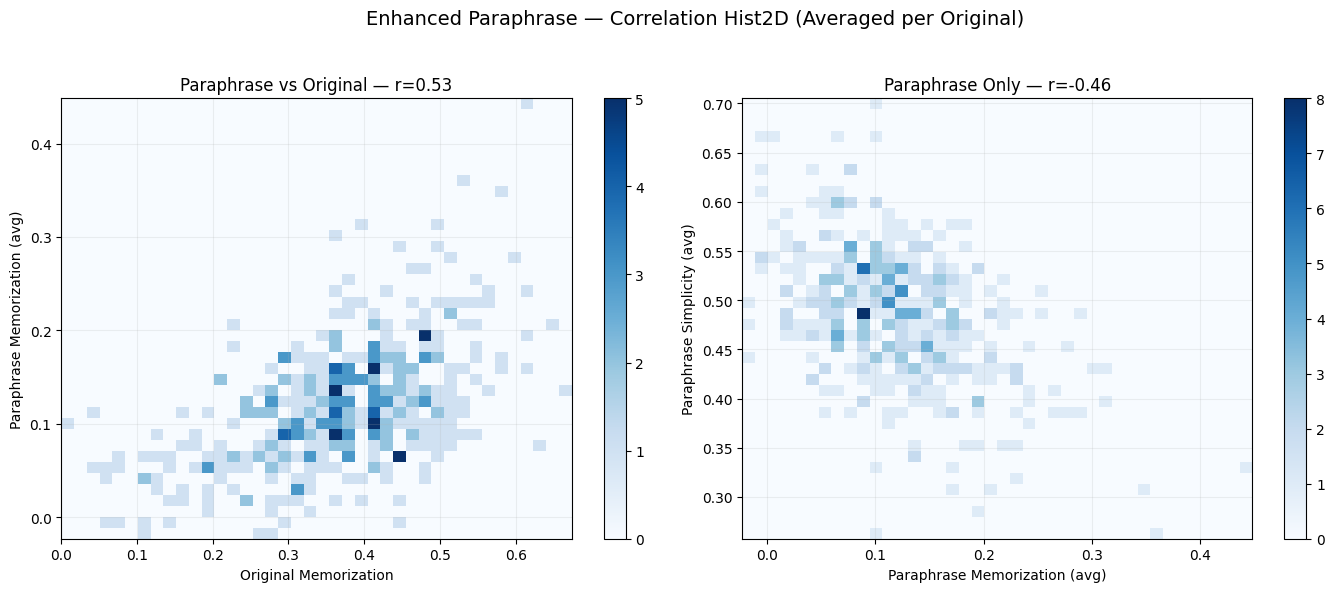

: 

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Load saved analysis results (your structure) ----
path = "/root/tofu/add/unlearning_analysis/results/enhanced_paraphrase_paraphrase_locuslab_TOFU_forget10_results.json"
with open(path, "r") as f:
    blob = json.load(f)

results = blob.get("results", [])
assert isinstance(results, list), "results must be a list"

# ---- 2) Aggregate: per-original averages over its paraphrases ----
orig_mem_list = []
para_mem_avg_list = []
para_simp_avg_list = []

for ex in results:
    if not isinstance(ex, dict):
        continue
    om = ex.get("OriginalMemorization")
    prs = ex.get("ParaphraseResults", [])
    if om is None or not isinstance(prs, list) or len(prs) == 0:
        continue
    
    pm_vals = []
    ps_vals = []
    for pr in prs:
        if not isinstance(pr, dict):
            continue
        pm = pr.get("paraphrase_memorization")
        ps = pr.get("paraphrase_simplicity")
        if isinstance(pm, (int, float)):
            pm_vals.append(float(pm))
        if isinstance(ps, (int, float)):
            ps_vals.append(float(ps))

    if len(pm_vals) == 0:
        continue

    orig_mem_list.append(float(om))
    para_mem_avg_list.append(float(np.mean(pm_vals)))
    para_simp_avg_list.append(float(np.mean(ps_vals)) if len(ps_vals) > 0 else np.nan)

orig_mem = np.array(orig_mem_list)
para_mem_avg = np.array(para_mem_avg_list)
para_simp_avg = np.array(para_simp_avg_list)

# ---- 3) Correlations ----
def safe_corr(a, b):
    a = np.asarray(a); b = np.asarray(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2 or np.std(a[mask]) == 0 or np.std(b[mask]) == 0:
        return float("nan")
    return float(np.corrcoef(a[mask], b[mask])[0,1])

r1 = safe_corr(orig_mem, para_mem_avg)
mask = ~np.isnan(para_simp_avg)
r2 = safe_corr(para_mem_avg[mask], para_simp_avg[mask])

# ---- 4) Two-panel hist2d plots (single color map) ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Original vs Paraphrase-avg Memorization
h1 = axes[0].hist2d(orig_mem, para_mem_avg, bins=40, cmap="Blues")
axes[0].set_xlabel("Original Memorization")
axes[0].set_ylabel("Paraphrase Memorization (avg)")
axes[0].set_title(f"Paraphrase vs Original — r={r1:.2f}")
axes[0].grid(True, alpha=0.2)
fig.colorbar(h1[3], ax=axes[0])

# Panel B: Paraphrase-avg Memorization vs Paraphrase-avg Simplicity
h2 = axes[1].hist2d(para_mem_avg[mask], para_simp_avg[mask], bins=40, cmap="Blues")
axes[1].set_xlabel("Paraphrase Memorization (avg)")
axes[1].set_ylabel("Paraphrase Simplicity (avg)")
axes[1].set_title(f"Paraphrase Only — r={r2:.2f}")
axes[1].grid(True, alpha=0.2)
fig.colorbar(h2[3], ax=axes[1])

fig.suptitle("Enhanced Paraphrase — Correlation Hist2D (Averaged per Original)", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.95])

# Also output a quick count so we can sanity-check
(len(orig_mem), len(para_mem_avg), np.sum(mask), out_path)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib.gridspec as gridspec
import seaborn as sns

def load_paraphrase_data(file_path):
    """패러프레이즈 분석 결과 데이터를 로드하고 처리"""
    with open(file_path, "r") as f:
        data = json.load(f)
    
    # 실제 데이터 구조에 맞게 처리
    if isinstance(data, dict) and "paraphrase_results" in data:
        results = data["paraphrase_results"]
    elif isinstance(data, dict) and "results" in data:
        results = data["results"]
    elif isinstance(data, list):
        results = data
    else:
        results = [data]  # 단일 결과인 경우
    
    # 데이터 추출
    rows = []
    for item in results:
        question_id = len([r for r in rows if r['question_type'] == 'Original'])
        
        # 원본 질문 데이터
        original_row = {
            'question_type': 'Original',
            'question': item['Question'],
            'memorization': item['OriginalMemorization'],
            'simplicity': item['OriginalSimplicity'],
            'question_id': question_id
        }
        rows.append(original_row)
        
        # 패러프레이즈 질문들 데이터
        for i, para_result in enumerate(item['ParaphraseResults']):
            para_row = {
                'question_type': f'Paraphrase_{i+1}',
                'question': para_result['paraphrased_question'],
                'memorization': para_result['paraphrase_memorization'],
                'simplicity': para_result['paraphrase_simplicity'],
                'memorization_diff': para_result['memorization_difference'],
                'simplicity_diff': para_result['simplicity_difference'],
                'question_id': question_id
            }
            rows.append(para_row)
    
    return pd.DataFrame(rows)

def create_paraphrase_visualization(df):
    """패러프레이즈 분석 결과 시각화"""
    # 색상 팔레트 설정
    colors = {'Original': '#2E86C1', 'Paraphrase_1': '#E74C3C', 
              'Paraphrase_2': '#F39C12', 'Paraphrase_3': '#27AE60'}
    
    # 그리드 레이아웃 정의 (더 복잡한 레이아웃)
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, wspace=0.3, hspace=0.3)
    
    # 1. 메인 산점도 - Original vs Paraphrases 비교
    ax_main = fig.add_subplot(gs[0, :2])
    for q_type in df['question_type'].unique():
        subset = df[df['question_type'] == q_type]
        ax_main.scatter(subset['memorization'], subset['simplicity'], 
                       c=colors.get(q_type, 'gray'), label=q_type, alpha=0.7, s=60)
    
    ax_main.set_xlabel("Memorization Score", fontsize=12)
    ax_main.set_ylabel("Simplicity Score", fontsize=12)
    ax_main.set_title("Original vs Paraphrase Questions\n(Memorization vs Simplicity)", 
                     fontsize=14, fontweight="bold")
    ax_main.legend()
    ax_main.grid(True, alpha=0.3)
    
    # 2. 차이점 분석 - 화살표로 변화 표시
    ax_diff = fig.add_subplot(gs[0, 2:])
    original_data = df[df['question_type'] == 'Original'].reset_index(drop=True)
    paraphrase_data = df[df['question_type'] != 'Original'].reset_index(drop=True)
    
    # 각 원본 질문에 대해 패러프레이즈들의 평균 변화를 계산
    for q_id in original_data['question_id'].unique():
        orig = original_data[original_data['question_id'] == q_id].iloc[0]
        paras = paraphrase_data[paraphrase_data['question_id'] == q_id]
        
        if len(paras) > 0:
            # 각 패러프레이즈에 대해 화살표 그리기
            for _, para in paras.iterrows():
                ax_diff.arrow(orig['memorization'], orig['simplicity'],
                            para['memorization'] - orig['memorization'],
                            para['simplicity'] - orig['simplicity'],
                            head_width=0.02, head_length=0.02, 
                            fc='red', ec='red', alpha=0.6, linewidth=1)
    
    # 원본 점들 표시
    ax_diff.scatter(original_data['memorization'], original_data['simplicity'], 
                   c='blue', s=100, alpha=0.8, label='Original', marker='o')
    # 패러프레이즈 점들 표시
    ax_diff.scatter(paraphrase_data['memorization'], paraphrase_data['simplicity'], 
                   c='red', s=60, alpha=0.6, label='Paraphrases', marker='x')
    
    ax_diff.set_xlabel("Memorization Score", fontsize=12)
    ax_diff.set_ylabel("Simplicity Score", fontsize=12)
    ax_diff.set_title("Change Direction\n(Original → Paraphrase)", fontsize=14, fontweight="bold")
    ax_diff.legend()
    ax_diff.grid(True, alpha=0.3)
    
    # 3. Memorization 차이 히스토그램
    ax_mem_diff = fig.add_subplot(gs[1, :2])
    paraphrase_only = df[df['question_type'] != 'Original']
    if 'memorization_diff' in paraphrase_only.columns:
        ax_mem_diff.hist(paraphrase_only['memorization_diff'], bins=20, 
                        color='lightcoral', edgecolor='black', alpha=0.7)
        ax_mem_diff.axvline(x=0, color='red', linestyle='--', linewidth=2, 
                           label='No Change')
        ax_mem_diff.axvline(x=paraphrase_only['memorization_diff'].mean(), 
                           color='darkred', linewidth=2, label='Mean')
    
    ax_mem_diff.set_xlabel("Memorization Difference (Paraphrase - Original)", fontsize=12)
    ax_mem_diff.set_ylabel("Count", fontsize=12)
    ax_mem_diff.set_title("Distribution of Memorization Changes", fontsize=14, fontweight="bold")
    ax_mem_diff.legend()
    ax_mem_diff.grid(True, alpha=0.3)
    
    # 4. Simplicity 차이 히스토그램
    ax_simp_diff = fig.add_subplot(gs[1, 2:])
    if 'simplicity_diff' in paraphrase_only.columns:
        ax_simp_diff.hist(paraphrase_only['simplicity_diff'], bins=20, 
                         color='lightblue', edgecolor='black', alpha=0.7)
        ax_simp_diff.axvline(x=0, color='blue', linestyle='--', linewidth=2, 
                            label='No Change')
        ax_simp_diff.axvline(x=paraphrase_only['simplicity_diff'].mean(), 
                            color='darkblue', linewidth=2, label='Mean')
    
    ax_simp_diff.set_xlabel("Simplicity Difference (Paraphrase - Original)", fontsize=12)
    ax_simp_diff.set_ylabel("Count", fontsize=12)
    ax_simp_diff.set_title("Distribution of Simplicity Changes", fontsize=14, fontweight="bold")
    ax_simp_diff.legend()
    ax_simp_diff.grid(True, alpha=0.3)
    
    # 5. 박스플롯 비교
    ax_box = fig.add_subplot(gs[2, :])
    
    # 데이터 재구성
    plot_data = []
    for _, row in df.iterrows():
        plot_data.append({'Type': row['question_type'], 
                         'Metric': 'Memorization', 
                         'Score': row['memorization']})
        plot_data.append({'Type': row['question_type'], 
                         'Metric': 'Simplicity', 
                         'Score': row['simplicity']})
    
    plot_df = pd.DataFrame(plot_data)
    
    # 박스플롯 생성
    sns.boxplot(data=plot_df, x='Type', y='Score', hue='Metric', ax=ax_box)
    ax_box.set_title("Score Distribution Comparison", fontsize=14, fontweight="bold")
    ax_box.set_xlabel("Question Type", fontsize=12)
    ax_box.set_ylabel("Score", fontsize=12)
    ax_box.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_summary_stats(df):
    """요약 통계 출력"""
    print("=" * 60)
    print("PARAPHRASE ANALYSIS SUMMARY")
    print("=" * 60)
    
    original_data = df[df['question_type'] == 'Original']
    paraphrase_data = df[df['question_type'] != 'Original']
    
    print(f"총 원본 질문 수: {len(original_data)}")
    print(f"총 패러프레이즈 질문 수: {len(paraphrase_data)}")
    
    print(f"\n원본 질문 통계:")
    print(f"  Memorization: {original_data['memorization'].mean():.3f} ± {original_data['memorization'].std():.3f}")
    print(f"  Simplicity: {original_data['simplicity'].mean():.3f} ± {original_data['simplicity'].std():.3f}")
    
    print(f"\n패러프레이즈 질문 통계:")
    print(f"  Memorization: {paraphrase_data['memorization'].mean():.3f} ± {paraphrase_data['memorization'].std():.3f}")
    print(f"  Simplicity: {paraphrase_data['simplicity'].mean():.3f} ± {paraphrase_data['simplicity'].std():.3f}")
    
    if 'memorization_diff' in paraphrase_data.columns:
        print(f"\n변화량 통계:")
        print(f"  Memorization 차이: {paraphrase_data['memorization_diff'].mean():.3f} ± {paraphrase_data['memorization_diff'].std():.3f}")
        print(f"  Simplicity 차이: {paraphrase_data['simplicity_diff'].mean():.3f} ± {paraphrase_data['simplicity_diff'].std():.3f}")

# 사용 예시
if __name__ == "__main__":
    # 실제 패러프레이즈 분석 결과 파일들
    json_files = [
        "/root/tofu/add/unlearning_analysis/results/enhanced_paraphrase_locuslab_TOFU_forget10_results.json",
        "/root/tofu/add/unlearning_analysis/results/enhanced_paraphrase_dual_locuslab_TOFU_forget10_results.json", 
        "/root/tofu/add/unlearning_analysis/results/enhanced_paraphrase_paraphrase_locuslab_TOFU_forget10_results.json"
    ]
    
    # 사용 가능한 파일 찾기
    available_file = None
    for file_path in json_files:
        import os
        if os.path.exists(file_path):
            available_file = file_path
            print(f"Using data file: {file_path}")
            break
    
    if available_file:
        try:
            # 데이터 로드 및 시각화
            df = load_paraphrase_data(available_file)
            print_summary_stats(df)
            fig = create_paraphrase_visualization(df)
            plt.savefig('/root/paraphrase_analysis_visualization.png', dpi=300, bbox_inches='tight')
            print(f"\n시각화 결과가 '/root/paraphrase_analysis_visualization.png'에 저장되었습니다.")
            plt.show()
            
        except Exception as e:
            print(f"파일 로드 중 오류 발생: {e}")
            print("파일 구조를 확인해보겠습니다...")
            
            # 파일 구조 확인
            with open(available_file, "r") as f:
                data = json.load(f)
            
            print(f"데이터 타입: {type(data)}")
            if isinstance(data, dict):
                print(f"딕셔너리 키들: {list(data.keys())}")
            elif isinstance(data, list):
                print(f"리스트 길이: {len(data)}")
                if len(data) > 0:
                    print(f"첫 번째 요소 키들: {list(data[0].keys()) if isinstance(data[0], dict) else 'Not a dict'}")
    else:
        print("패러프레이즈 분석 결과 파일을 찾을 수 없습니다.")
        print("다음 경로들을 확인해주세요:")
        for file_path in json_files:
            print(f"  - {file_path}")

ModuleNotFoundError: No module named 'seaborn'

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# --- Load files ---
with open('/root/tofu/add/unlearning_analysis/gradient_alignment_results.json', 'r', encoding='utf-8') as f:
    grad_data = json.load(f)
with open('/root/tofu/add/unlearning_analysis/results/enhanced_paraphrase_paraphrase_locuslab_TOFU_forget10_results.json', 'r', encoding='utf-8') as f:
    para_data = json.load(f)

# --- Build DF for mean cosine alignment per question ---
indiv = grad_data["individual_results"]
df = pd.DataFrame([{
    "question_index": r["question_index"],
    "paraphrase_index": r["paraphrase_index"],
    "align_inner": r["statistics"]["mean_align_inner"],
    "align_cosine": r["statistics"]["mean_align_cosine"],
} for r in indiv])

df_avg = df.groupby("question_index").agg(
    mean_inner=("align_inner", "mean"),
    mean_cosine=("align_cosine", "mean")
).reset_index()

# --- Original memorization scores from 2nd file ---
mem_records = []
for i, item in enumerate(para_data.get("results", [])):
    mem_records.append({
        "question_index": i,
        "orig_mem": item.get("OriginalMemorization", None)
    })
df_mem = pd.DataFrame(mem_records)

# --- Merge ---
df_merged = pd.merge(df_avg, df_mem, on="question_index", how="inner").dropna()

# --- Correlations (cosine vs memorization) ---
pearson = df_merged["orig_mem"].corr(df_merged["mean_inner"], method="pearson")
spearman = df_merged["orig_mem"].corr(df_merged["mean_inner"], method="spearman")

# --- Gridspec layout (hexbin + side histograms) ---
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# Main hexbin (using PuBu colormap for pretty blue)
ax_main = fig.add_subplot(gs[1:, :3])
hb = ax_main.hexbin(
    df_merged["orig_mem"], 
    df_merged["mean_cosine"],
    gridsize=30,
    cmap="PuBu",
    mincnt=1
)
ax_main.set_xlabel("Original Memorization", fontsize=12)
ax_main.set_ylabel("Mean Cosine Alignment", fontsize=12)
ax_main.set_title(f"Memorization vs Mean Cosine Alignment\nPearson={pearson:.3f}, Spearman={spearman:.3f}", fontsize=14, fontweight="bold")
ax_main.grid(alpha=0.3)

# Right histogram
ax_right = fig.add_subplot(gs[1:, 3], sharey=ax_main)
ax_right.hist(df_merged["mean_cosine"], bins=30, orientation="horizontal", color="skyblue", edgecolor="k")
ax_right.set_xlabel("Count")
ax_right.grid(alpha=0.3)

# Top histogram
ax_top = fig.add_subplot(gs[0, :3], sharex=ax_main)
ax_top.hist(df_merged["orig_mem"], bins=30, color="skyblue", edgecolor="k")
ax_top.set_ylabel("Count")
ax_top.grid(alpha=0.3)

# Colorbar
cbar = plt.colorbar(hb, ax=ax_main, label="Count", orientation="vertical")

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/root/tofu/add/unlearning_analysis/gradient_alignment_results.json'

   question_index  mean_inner_alignment
0               0            548.596749
1               1           1256.468443
2               2            368.803149
3               3            653.797761
4               4            627.790453


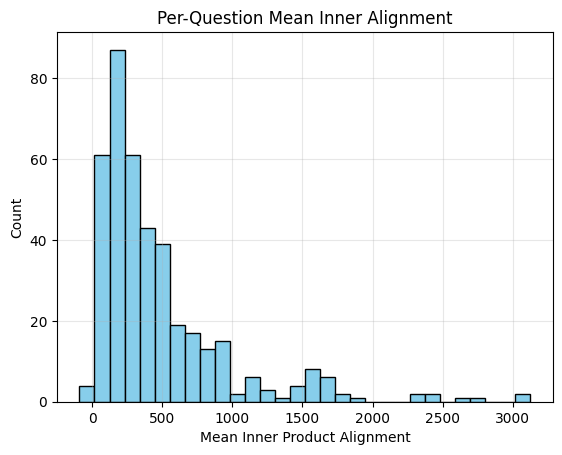

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the gradient alignment results
with open('/root/tofu/add/unlearning_analysis/gradient_alignment_results.json', 'r', encoding='utf-8') as f:
    grad_data = json.load(f)

results = grad_data["individual_results"]
image.png
# Convert to DataFrame
df = pd.DataFrame([{
    "question_index": r["question_index"],
    "paraphrase_index": r["paraphrase_index"],
    "original_text": r["original_text"],
    "paraphrase_text": r["paraphrase_text"],
    "align_inner": r["statistics"]["mean_align_inner"],
    "align_cosine": r["statistics"]["mean_align_cosine"],
    "grad_norm_orig": r["statistics"]["mean_grad_norm_orig"],
    "grad_norm_para": r["statistics"]["mean_grad_norm_para"]
} for r in results])

# Compute per-question averages
df_avg = df.groupby("question_index").agg({
    "align_cosine": "mean",
    "align_inner": "mean"
}).reset_index()


# question_index 단위로 평균 inner product alignment 계산
df_inner_avg = df.groupby("question_index")["align_inner"].mean().reset_index()
df_inner_avg.rename(columns={"align_inner": "mean_inner_alignment"}, inplace=True)

# 결과 확인
print(df_inner_avg.head())

# 분포 시각화
plt.hist(df_inner_avg["mean_inner_alignment"], bins=30, color="skyblue", edgecolor="k")
plt.title("Per-Question Mean Inner Alignment")
plt.xlabel("Mean Inner Product Alignment")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()



In [7]:
import json
import pandas as pd

# JSON 파일 로드
with open('/root/tofu/add/unlearning_analysis/results/enhanced_paraphrase_paraphrase_locuslab_TOFU_forget10_results.json', 'r', encoding='utf-8') as f:
    grad_data = json.load(f)

# results 키 사용 (individual_results가 아님)
results = grad_data["results"]

# DataFrame 생성 - 실제 JSON 구조에 맞게 수정
df_data = []
for question_idx, question_result in enumerate(results):
    for paraphrase_result in question_result["ParaphraseResults"]:
        df_data.append({
            "question_index": question_idx,
            "paraphrase_index": paraphrase_result["index"],
            "strategy": paraphrase_result["strategy"],
            "original_question": paraphrase_result["original_question"],
            "paraphrased_question": paraphrase_result["paraphrased_question"],
            "original_acc_in": paraphrase_result["original_acc_in"],
            "original_acc_out": paraphrase_result["original_acc_out"],
            "paraphrase_acc_in": paraphrase_result["paraphrase_acc_in"],
            "paraphrase_acc_out": paraphrase_result["paraphrase_acc_out"],
            "memorization_difference": paraphrase_result["memorization_difference"],
            "simplicity_difference": paraphrase_result["simplicity_difference"]
        })

df = pd.DataFrame(df_data)
print("DataFrame 컬럼들:", df.columns.tolist())
print("\nDataFrame head:")
print(df.head())
# --- Compute per-question average inner alignment ---
# align_inner 컬럼이 없으므로 다른 컬럼을 사용하거나 계산해야 합니다
# 현재 사용 가능한 컬럼들: question_index, paraphrase_index, strategy, original_question, paraphrased_question, 
# original_acc_in, original_acc_out, paraphrase_acc_in, paraphrase_acc_out, memorization_difference, simplicity_difference

# memorization_difference를 사용하여 평균 계산
df_inner_avg = df.groupby("question_index")["memorization_difference"].mean().reset_index()
df_inner_avg.rename(columns={"memorization_difference": "mean_memorization_difference"}, inplace=True)

# --- Merge with original/paraphrase text (원문 하나만 대표로 가져오기 위해 drop_duplicates) ---
df_texts = df.drop_duplicates(subset=["question_index"])[["question_index", "original_question"]]
df_merged = pd.merge(df_inner_avg, df_texts, on="question_index", how="left")

# --- Top-k / Bottom-k 추출 ---
k = 5  # 원하는 개수
lowest_k = df_merged.nsmallest(k, "mean_memorization_difference")
highest_k = df_merged.nlargest(k, "mean_memorization_difference")

print("🔽 가장 낮은 mean_memorization_difference 질문들:")
print(lowest_k[["question_index", "mean_memorization_difference", "original_question"]].to_string(index=False))

print("\n🔼 가장 높은 mean_memorization_difference 질문들:")
print(highest_k[["question_index", "mean_memorization_difference", "original_question"]].to_string(index=False))

# --- 심플리시티 비교 분석 ---
print("\n" + "="*80)
print("📊 심플리시티 비교 분석")
print("="*80)

# 원본 데이터에서 심플리시티 정보 추출
simplicity_data = []
for question_idx, question_result in enumerate(results):
    original_simplicity = question_result.get("OriginalSimplicity", 0)
    
    # 패러프레이즈들의 심플리시티 평균 계산
    paraphrase_simplicities = []
    for paraphrase_result in question_result.get("ParaphraseResults", []):
        para_simplicity = paraphrase_result.get("paraphrase_simplicity", 0)
        paraphrase_simplicities.append(para_simplicity)
    
    if paraphrase_simplicities:
        avg_para_simplicity = sum(paraphrase_simplicities) / len(paraphrase_simplicities)
        simplicity_diff = original_simplicity - avg_para_simplicity
        
        simplicity_data.append({
            "question_index": question_idx,
            "original_question": question_result.get("Question", ""),
            "original_simplicity": original_simplicity,
            "avg_paraphrase_simplicity": avg_para_simplicity,
            "simplicity_difference": simplicity_diff,
            "num_paraphrases": len(paraphrase_simplicities)
        })

simplicity_df = pd.DataFrame(simplicity_data)

# 1. 원본 심플리시티가 높은 경우 (원본이 더 간단함)
original_higher = simplicity_df[simplicity_df["simplicity_difference"] > 0].copy()
original_higher = original_higher.sort_values("simplicity_difference", ascending=False)

print(f"\n🔺 원본 심플리시티가 높은 경우 (원본이 더 간단함): {len(original_higher)}개")
print(f"평균 차이: {original_higher['simplicity_difference'].mean():.4f}")
print("\n상위 5개:")
for idx, row in original_higher.head().iterrows():
    print(f"\n질문 {row['question_index']}:")
    print(f"  원본 심플리시티: {row['original_simplicity']:.4f}")
    print(f"  패러프레이즈 평균: {row['avg_paraphrase_simplicity']:.4f}")
    print(f"  차이: {row['simplicity_difference']:.4f}")
    print(f"  질문: {row['original_question'][:100]}...")

# 2. 패러프레이즈 심플리시티가 높은 경우 (패러프레이즈가 더 간단함)
paraphrase_higher = simplicity_df[simplicity_df["simplicity_difference"] < 0].copy()
paraphrase_higher = paraphrase_higher.sort_values("simplicity_difference", ascending=True)

print(f"\n🔻 패러프레이즈 심플리시티가 높은 경우 (패러프레이즈가 더 간단함): {len(paraphrase_higher)}개")
print(f"평균 차이: {paraphrase_higher['simplicity_difference'].mean():.4f}")
print("\n상위 5개:")
for idx, row in paraphrase_higher.head().iterrows():
    print(f"\n질문 {row['question_index']}:")
    print(f"  원본 심플리시티: {row['original_simplicity']:.4f}")
    print(f"  패러프레이즈 평균: {row['avg_paraphrase_simplicity']:.4f}")
    print(f"  차이: {row['simplicity_difference']:.4f}")
    print(f"  질문: {row['original_question'][:100]}...")

# 3. 통계 요약
print(f"\n📈 전체 통계:")
print(f"  전체 질문 수: {len(simplicity_df)}")
print(f"  원본이 더 간단한 경우: {len(original_higher)} ({len(original_higher)/len(simplicity_df)*100:.1f}%)")
print(f"  패러프레이즈가 더 간단한 경우: {len(paraphrase_higher)} ({len(paraphrase_higher)/len(simplicity_df)*100:.1f}%)")
print(f"  평균 원본 심플리시티: {simplicity_df['original_simplicity'].mean():.4f}")
print(f"  평균 패러프레이즈 심플리시티: {simplicity_df['avg_paraphrase_simplicity'].mean():.4f}")
print(f"  평균 차이: {simplicity_df['simplicity_difference'].mean():.4f}")


DataFrame 컬럼들: ['question_index', 'paraphrase_index', 'strategy', 'original_question', 'paraphrased_question', 'original_acc_in', 'original_acc_out', 'paraphrase_acc_in', 'paraphrase_acc_out', 'memorization_difference', 'simplicity_difference']

DataFrame head:
   question_index  paraphrase_index                   strategy  \
0               0                 0  counterfactual_paraphrase   
1               0                 1  counterfactual_paraphrase   
2               1                 0  counterfactual_paraphrase   
3               1                 1  counterfactual_paraphrase   
4               1                 2  counterfactual_paraphrase   

                                   original_question  \
0  Question: What is the full name of the author ...   
1  Question: What is the full name of the author ...   
2  Question: What does Hsiao Yun-Hwa identify as ...   
3  Question: What does Hsiao Yun-Hwa identify as ...   
4  Question: What does Hsiao Yun-Hwa identify as ...   

    

# Paraphrase Analysis Visualization

This notebook imports and visualizes the results from `paraphrase_visualizer.py` that are saved as JSON files.

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from sklearn.decomposition import PCA

# Configuration
RESULTS_DIR = Path("/root/task_vector/tofu/add/unlearning_analysis/results")
AVAILABLE_RESULTS = [
    "enhanced_paraphrase_locuslab_TOFU_forget10_results.json",
    "enhanced_paraphrase_dual_locuslab_TOFU_forget10_results.json",
    "enhanced_paraphrase_paraphrase_locuslab_TOFU_forget10_results.json"
]

def load_paraphrase_results(file_path):
    """Load paraphrase analysis results from JSON file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def extract_statistics(data):
    """Extract key statistics from results"""
    results = data.get("results", [])
    
    stats = {
        'n_questions': len(results),
        'original_memorization': [],
        'original_simplicity': [],
        'paraphrase_memorization': [],
        'paraphrase_simplicity': [],
        'memorization_diff': [],
        'simplicity_diff': []
    }
    
    for item in results:
        # Original scores
        stats['original_memorization'].append(item.get('OriginalMemorization', np.nan))
        stats['original_simplicity'].append(item.get('OriginalSimplicity', np.nan))
        
        # Paraphrase scores
        para_results = item.get('ParaphraseResults', [])
        for pr in para_results:
            stats['paraphrase_memorization'].append(pr.get('paraphrase_memorization', np.nan))
            stats['paraphrase_simplicity'].append(pr.get('paraphrase_simplicity', np.nan))
            stats['memorization_diff'].append(pr.get('memorization_difference', np.nan))
            stats['simplicity_diff'].append(pr.get('simplicity_difference', np.nan))
    
    # Convert to numpy arrays
    for key in stats:
        if isinstance(stats[key], list):
            stats[key] = np.array(stats[key])
    
    return stats

# Check available files
available_files = []
for filename in AVAILABLE_RESULTS:
    file_path = RESULTS_DIR / filename
    if file_path.exists():
        available_files.append(file_path)
        print(f"✓ Found: {filename}")
    else:
        print(f"✗ Missing: {filename}")

print(f"\nTotal available files: {len(available_files)}")


## 1. Overview Statistics

In [ ]:
# Load and display basic statistics for all available files
if available_files:
    # Use the first available file
    data = load_paraphrase_results(available_files[0])
    stats = extract_statistics(data)
    
    print("=" * 70)
    print("PARAPHRASE ANALYSIS SUMMARY")
    print("=" * 70)
    print(f"\nFile: {available_files[0].name}")
    print(f"Total Questions: {stats['n_questions']}")
    print(f"Total Paraphrases: {len(stats['paraphrase_memorization'])}")
    
    print("\n--- Original Questions ---")
    print(f"Memorization: {np.nanmean(stats['original_memorization']):.4f} ± {np.nanstd(stats['original_memorization']):.4f}")
    print(f"Simplicity:   {np.nanmean(stats['original_simplicity']):.4f} ± {np.nanstd(stats['original_simplicity']):.4f}")
    
    print("\n--- Paraphrase Questions ---")
    print(f"Memorization: {np.nanmean(stats['paraphrase_memorization']):.4f} ± {np.nanstd(stats['paraphrase_memorization']):.4f}")
    print(f"Simplicity:   {np.nanmean(stats['paraphrase_simplicity']):.4f} ± {np.nanstd(stats['paraphrase_simplicity']):.4f}")
    
    print("\n--- Differences (Paraphrase - Original) ---")
    print(f"Memorization Diff: {np.nanmean(stats['memorization_diff']):.4f} ± {np.nanstd(stats['memorization_diff']):.4f}")
    print(f"Simplicity Diff:   {np.nanmean(stats['simplicity_diff']):.4f} ± {np.nanstd(stats['simplicity_diff']):.4f}")
    
    print("\n--- Correlation ---")
    # Calculate correlation between original memorization and simplicity
    mask = ~(np.isnan(stats['original_memorization']) | np.isnan(stats['original_simplicity']))
    if mask.sum() > 0:
        corr_orig = np.corrcoef(stats['original_memorization'][mask], 
                                stats['original_simplicity'][mask])[0, 1]
        print(f"Original Mem vs Simp: {corr_orig:.4f}")
    
    # Calculate correlation for paraphrases
    mask = ~(np.isnan(stats['paraphrase_memorization']) | np.isnan(stats['paraphrase_simplicity']))
    if mask.sum() > 0:
        corr_para = np.corrcoef(stats['paraphrase_memorization'][mask], 
                               stats['paraphrase_simplicity'][mask])[0, 1]
        print(f"Para Mem vs Simp:     {corr_para:.4f}")
else:
    print("No result files found!")
